# Load the necessary packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Neural Networks
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from skimage import io, transform

#Matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import numpy as np

#For image processing and the Dataset class
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from PIL import Image

#CSV and File management
import os
import pandas as pd

#Plot Recall, Precision, and F1 neatly
from utility.evaluation import load_type_dict, plot_evaluation

#Display matplotlib within jupyter notebook
plt.ion()

In [3]:
data_folder = os.path.join(os.getcwd(), "data")

train_df = pd.read_csv(os.path.join(data_folder, "Train.csv"))
test_df  = pd.read_csv(os.path.join(data_folder, "Test.csv" ))

# The following cell plots all Pokemon of a given Pokedex number, specified from a csv dataframe

Note: it also returns a dataframe of the specified pokemon and their labels + dexnum

[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)


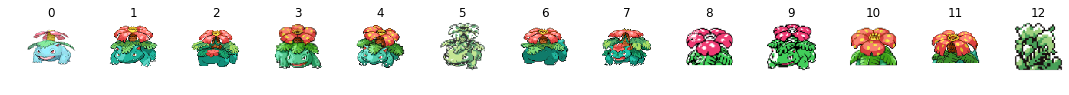

                                              pokemon dex_number normal  \
21  /home/tariq/PokemonTypeNN/data/xydex/venusaur.png          3      0   
22     /home/tariq/PokemonTypeNN/data/bw/venusaur.png          3      0   
23  /home/tariq/PokemonTypeNN/data/bw-back/venusau...          3      0   
24    /home/tariq/PokemonTypeNN/data/rse/venusaur.png          3      0   
25    /home/tariq/PokemonTypeNN/data/dpp/venusaur.png          3      0   
26    /home/tariq/PokemonTypeNN/data/rby/venusaur.png          3      0   
27  /home/tariq/PokemonTypeNN/data/bw-back/venusau...          3      0   
28  /home/tariq/PokemonTypeNN/data/bw/venusaurmega...          3      0   
29  /home/tariq/PokemonTypeNN/data/gsc-back/venusa...          3      0   
30    /home/tariq/PokemonTypeNN/data/gsc/venusaur.png          3      0   
31  /home/tariq/PokemonTypeNN/data/rse-back/venusa...          3      0   
32  /home/tariq/PokemonTypeNN/data/dpp-back/venusa...          3      0   
33  /home/tariq/PokemonTy

In [4]:
def plot_all(dex_num, df):

    df_idxs = [i for i in range(0,len(df)) if df["dex_number"].iloc[i] == dex_num]
    print(df_idxs)
    fig = plt.figure(figsize=(15,15))
    labels = pd.DataFrame(columns=list(df))
    
    for i in range(0, len(df_idxs)):
        
        ax = plt.subplot(1, len(df_idxs), i+1)
        plt.tight_layout()
        ax.set_title(i)
        ax.axis("off")
        pkm_image = io.imread(df["pokemon"].iloc[ df_idxs[i] ])
        plt.imshow(pkm_image)
        print(np.array(pkm_image).shape)
        labels = labels.append(df.iloc[ df_idxs[i]])

    plt.show()
    return labels

#plot an example
temp_labels = plot_all(3,train_df)
print(temp_labels)

# Create the PokemonDataset (loads the project's Train/Test.csv formats)

inspiration: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [5]:
class PokemonDataset(Dataset):
    """Pokemon Dataset. """
    
    def __init__(self, csv_file_loc, transform=None):
        """
        Args:
            csv_file_loc (string): Path to the csv file
            transform (callable, optional): Optional transform to be applied to the sample
        
        """
        self.df = pd.read_csv(csv_file_loc)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name = self.df["pokemon"].iloc[index]
        
        #Read the Image
        image = io.imread(img_name)
        if self.transform:
            image  = self.transform(image )
            
        #Read the labels
        labels = self.df.iloc[index, 2:].values
        labels = labels.astype("float").reshape(len(labels))
        
        #Concat the images and labels as a "Sample" dictionary
        sample = {"image": image, "labels": labels}
        return sample, index
    
    def getpokemon(self, index):
        return self.df["pokemon"].iloc[index]

# Create Transformation Classes

In [6]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    
    def __call__(self, sample):
        image, labels = sample["image"], sample["labels"]
        
        #swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        
        image = image.transpose((2, 0, 1))
        return {"image": torch.from_numpy(image),
                "labels": torch.from_numpy(labels)}

# Load the Pokemon Datasets for the Neural Network

In [7]:
use_devset = True


theTransformations = transforms.Compose([transforms.ToPILImage(),
                                         transforms.RandomAffine(degrees=40, translate=(0.2, 0.2), 
                                                                 shear =0.2, scale=(1, 1.3),
                                                                 fillcolor=(255,255,255)),
                                         transforms.RandomHorizontalFlip(p=0.5),
                                         transforms.ToTensor()])

#Trainset uses theTransformations; Test set only uses ToTensor
trainset = PokemonDataset(csv_file_loc = os.path.join(data_folder, "Train.csv"),
                         transform = theTransformations)
testset  = PokemonDataset(csv_file_loc = os.path.join(data_folder, "Test.csv" ),
                         transform = transforms.Compose([transforms.ToTensor()]))
if use_devset:
    devset   = PokemonDataset(csv_file_loc = os.path.join(data_folder, "Dev.csv"  ),
                             transform = transforms.Compose([transforms.ToTensor()]))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                         shuffle=True,  num_workers=4) #num_workers = 2
testloader  = torch.utils.data.DataLoader(testset , batch_size=16,
                                         shuffle=False, num_workers=4)
if use_devset:
    devloader   = torch.utils.data.DataLoader(devset  , batch_size=16,
                                         shuffle=False, num_workers=4)

classes = list(train_df)[2:]
print(classes)

['normal', 'fighting', 'flying', 'poison', 'ground', 'rock', 'bug', 'ghost', 'steel', 'fire', 'water', 'grass', 'electric', 'psychic', 'ice', 'dragon', 'dark', 'fairy']


# Test with some Training Images

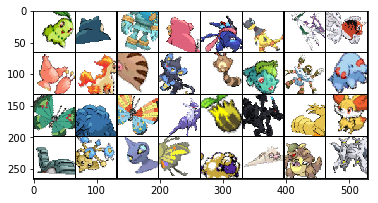

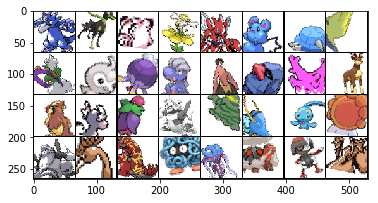

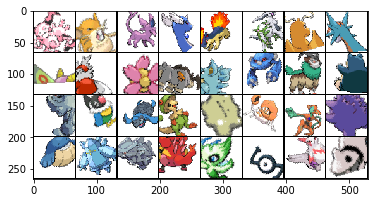

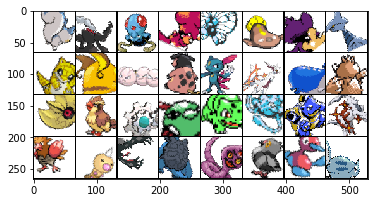

In [8]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

#get some random training images
dataiter = iter(trainloader)

for i in range(0,4):
    minibatch, index = dataiter.next()
    images, labels = minibatch["image"], minibatch["labels"]

    #show images
    imshow(torchvision.utils.make_grid(images))



# Define a Convolutional Neural Network!

In [9]:
#Print if cuda is available
print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)


True
cuda:0


In [10]:
# 
# check for multi-classification: https: //stackoverflow.com/questions/52855843/multi-label-classification-in-pytorch
# check for explanation of NN parameters: https://www.aiworkbox.com/lessons/how-to-define-a-convolutional-layer-in-pytorch
# check for reference model: https://nextjournal.com/gkoehler/pytorch-mnist
# loss function: BCELoss
# use sigmoid for multiple classes?

# Use THIS PAGE to calculate matrix outputs: https://pytorch.org/docs/stable/nn.html#torch.nn.MaxPool2d

# goal: convolve -> ReLu -> pool -> convolve -> ReLu -> pool -> Linear -> ReLu -> Linear -> ReLu -> Linear -> Sigmoid
# Loss function: BCELoss

class ShallowNet(nn.Module):
    def __init__(self, name):
        super(ShallowNet, self).__init__()
        
        #in_channels = number of colors (3), out_channels are the desired number to be learned, and 
        #kernel_size says whether to use nearby pixels  
        
        #TODO: remove stride in CNN (stride only later)
        # probably don't need so many linear layers
        # Add regularization
        # Do random shuffle to prpove that the network works
        self.setName(name)
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size = 5, stride=2) # 6 output
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=18, kernel_size = 5, stride=2) #12 output
        self.fc1 = nn.Linear(in_features = 162, out_features= 120) #in_features=108
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 18)
        
        self.bnorm1 = nn.BatchNorm2d(num_features=6)
        self.bnorm2 = nn.BatchNorm2d(num_features=18)
        self.bnormfc1 = nn.BatchNorm1d(num_features=120)
        self.bnormfc2 = nn.BatchNorm1d(num_features=84)
        
    def setName(self,name):
        self.name = name
        
    def getName(self):
        return self.name  
    
    def forward(self, x):
        x = self.pool(F.relu(self.bnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.bnorm2(self.conv2(x))))
        x = x.view(x.shape[0], -1)
        #print(x.shape)
        x = F.relu(self.bnormfc1(self.fc1(x)))
        x = F.relu(self.bnormfc2(self.fc2(x)))
        x = F.sigmoid(self.fc3(x))
        return x

In [11]:
# 
# check for multi-classification: https: //stackoverflow.com/questions/52855843/multi-label-classification-in-pytorch
# check for explanation of NN parameters: https://www.aiworkbox.com/lessons/how-to-define-a-convolutional-layer-in-pytorch
# check for reference model: https://nextjournal.com/gkoehler/pytorch-mnist
# loss function: BCELoss
# use sigmoid for multiple classes?

# Use THIS PAGE to calculate matrix outputs: https://pytorch.org/docs/stable/nn.html#torch.nn.MaxPool2d

# goal: convolve -> ReLu -> pool -> convolve -> ReLu -> pool -> Linear -> ReLu -> Linear -> ReLu -> Linear -> Sigmoid
# Loss function: BCELoss

class Net(nn.Module):
        
    def __init__(self, name="noNameProvided"):
        super(Net, self).__init__()
        #in_channels = number of colors (3), out_channels are the desired number to be learned, and 
        #kernel_size says whether to use nearby pixels  
        
        #TODO: remove stride in CNN (stride only later)
        # probably don't need so many linear layers
        # Add regularization
        # Do random shuffle to prpove that the network works
        
        self.setName(name)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size = 5, stride=1) # 6 output
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=18, kernel_size = 5, stride=1) #18 output
        self.conv3 = nn.Conv2d(in_channels=18, out_channels=32, kernel_size = 5, stride=1) #32 output
        self.fc1 = nn.Linear(in_features = 512, out_features= 120) #in_features=512
        self.fc2 = nn.Linear(in_features = 120, out_features = 84)
        self.fc3 = nn.Linear(in_features = 84, out_features=18)
        
        self.bnorm1 = nn.BatchNorm2d(num_features=6)
        self.bnorm2 = nn.BatchNorm2d(num_features=18)
        self.bnorm3 = nn.BatchNorm2d(num_features=32)
        
        self.bnormfc1 = nn.BatchNorm1d(num_features=120)
        self.bnormfc2 = nn.BatchNorm1d(num_features=84)
        
    def setName(self,name):
        self.name = name
        
    def getName(self):
        return self.name
        
    def forward(self, x):
        x = self.pool(F.relu(self.bnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.bnorm2(self.conv2(x))))
        x = self.pool(F.relu(self.bnorm3(self.conv3(x))))
        x = x.view(x.shape[0], -1)
        #print(x.shape)
        x = F.relu(self.bnormfc1(self.fc1(x)))
        x = F.relu(self.bnormfc2(self.fc2(x)))
        x = F.sigmoid(self.fc3(x))
        return x

In [12]:
###
# DEEPER NEURAL NETWORK

class DeepNet(nn.Module):
        
    def __init__(self, name="noNameProvided"):
        super(DeepNet, self).__init__()
        #in_channels = number of colors (3), out_channels are the desired number to be learned, and 
        #kernel_size says whether to use nearby pixels  
        
        #TODO: remove stride in CNN (stride only later)
        # probably don't need so many linear layers
        # Add regularization
        # Do random shuffle to prpove that the network works
        
        self.setName(name)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size = 5, stride=1) # 6 output
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=18, kernel_size = 5, stride=1) #18 output
        self.conv3 = nn.Conv2d(in_channels=18, out_channels=32, kernel_size = 5, stride=1) #32 output
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size = 3, stride=1) #64 output
        self.fc1 = nn.Linear(in_features = 64, out_features= 32) #in_features=64
        self.fc2 = nn.Linear(in_features = 32, out_features = 18)
        
        self.bnorm1 = nn.BatchNorm2d(num_features=6)
        self.bnorm2 = nn.BatchNorm2d(num_features=18)
        self.bnorm3 = nn.BatchNorm2d(num_features=32)
        self.bnorm4 = nn.BatchNorm2d(num_features=64)
        
        self.bnormfc1 = nn.BatchNorm1d(num_features=32)
        
    def setName(self,name):
        self.name = name
        
    def getName(self):
        return self.name
        
    def forward(self, x):
        x = self.pool(F.relu(self.bnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.bnorm2(self.conv2(x))))
        x = self.pool(F.relu(self.bnorm3(self.conv3(x))))
        x = self.pool(F.relu(self.bnorm4(self.conv4(x))))
        x = x.view(x.shape[0], -1)
        #print(x.shape)
        x = F.relu(self.bnormfc1(self.fc1(x)))
        x = F.sigmoid(self.fc2(x))
        return x

# Analyze the results of pre-built neural networks

In [ ]:
my_opts = ["2Con3FC", "3Con3FC", "4Con2FC"]
min_loss =  [0 , 0 , 0]
min_epoch = [0 , 0 , 0]

for i in range(0,len(my_opts)):
    my_name = my_opts[i]
    state = torch.load(os.path.join(os.getcwd(), "model",my_name+".pt"))
    saved_losses["dev"]   = state["dev_loss"]
    min_epoch[i] = np.argmin(saved_losses["dev"])
    min_loss[i]  = np.round(saved_losses["dev"][min_epoch[i]], decimals=3)
    
print("The networks :: ", my_opts)
print("The losses   :: ", min_loss)
print("The epochs   :: ", min_epoch)

In [33]:
type_of_network = "4Con2FC"

if(type_of_network == "2Con3FC"):
    net = ShallowNet("2Con3FC")
elif(type_of_network == "3Con3FC"):
    net = Net("3Con3FC")
elif(type_of_network == "4Con2FC"):
    net = DeepNet("4Con2FC")
else:
    raise ValueError("Improper Type of Network")
    
print("Finished setting up Neural Network :: ", net.getName())

Finished setting up Neural Network ::  Deep4Con2FC


# Define a loss function and an optimizer

In [34]:
import torch.optim as optim

loss_fn = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001) #0.001

use_cuda = False #True

#saved_losses=[]

# Train the Network

In [36]:
#Determine whether to load the model

load_model = False
saved_losses = {"train":[],
                "dev":[]}

if load_model:
    state = torch.load(os.path.join(os.getcwd(), "model",net.getName()+".pt"))
    net.load_state_dict(state["state_dict"])
    optimizer.load_state_dict(state["optimizer"])
    saved_losses["train"] = state["train_loss"]
    saved_losses["dev"]   = state["dev_loss"]
    
    plt.title("Training Loss vs Epochs")
    plt.plot(saved_losses["train"], label="Train")
    plt.plot(saved_losses["dev"], label="Dev")
    plt.legend(loc="upper right")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/torch/cuda/__init__.py:117: UserWarning: 
    Found GPU0 GeForce GT 755M which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


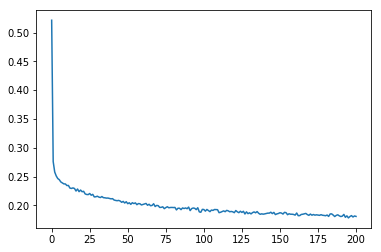

In [14]:
# #Determine whether to load the model

# load_model = True
# saved_losses = []

# if load_model:
#     state = torch.load(os.path.join(os.getcwd(), "model",net.getName()+".pt"))
#     net.load_state_dict(state["state_dict"])
#     optimizer.load_state_dict(state["optimizer"])
#     saved_losses = state["saved_losses"]
#     plt.plot(saved_losses)
    


# Validation and Training Error

In [38]:
max_epochs = 100

#epochs_to_print = 100

if use_cuda:
    net.cuda()
    
data_loaders = {"train":trainloader, 
                "dev":devloader}
data_lengths = {"train":len(trainloader), 
                "dev":  len(devloader) }

for epoch in range(max_epochs):
    
    for phase in ["train", "dev"]:
        
        running_loss = 0.0
        
        if phase == "train":
#             optimizer = scheduler(optimizer, epoch)
            net.train(True)
        else:
            net.train(False)
    
        for i, (minibatch, index) in enumerate(data_loaders[phase]):
            #get the inputs
            images, labels = minibatch["image"], minibatch["labels"]
            if use_cuda:
                images = images.float().cuda()
                labels = labels.float().cuda()
            else:
                images = images.float()
                labels = labels.float()


            #zero the parameter gradients
            optimizer.zero_grad()

            #forward + backward + optimize
            outputs = net(images) #net.forward()
            loss = loss_fn(outputs, labels)
            
            if phase == "train":
                loss.backward()
                optimizer.step()

            #print statistics
            running_loss += loss.item()

        running_loss /= data_lengths[phase]
        saved_losses[phase].append(running_loss)
        print('%5s [%d, %5d] loss: %.4f' %
               (phase, epoch + 1, i + 1, running_loss))

### 
# Save the Model
###
saveloc = os.path.join(os.getcwd(), "model")
print("*************************************************************************")
if(not os.path.exists(saveloc)):
    try:
        os.mkdir(saveloc)
    except OSError:
        print("Creation of the directory %s failed" %saveloc)
    else:
        print("Successfully created the directory %s" %saveloc)
print("*************************************************************************")
state = {
    "epoch"     : epoch,
    "state_dict": net.state_dict(),
    "optimizer" : optimizer.state_dict(),
    "train_loss": saved_losses["train"],
    "dev_loss"  : saved_losses["dev"]
}
torch.save(state, os.path.join(saveloc,net.getName()+".pt"))
print("Finished training")

train [1,   161] loss: 0.2392
  dev [1,    17] loss: 0.2388


Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tariq/anaconda3/envs/pokemon/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/tariq/anaconda3/envs/pokemon/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/tariq/anaconda3/envs/pokemon/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/tariq/anaconda3/envs/pokemon/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/tariq/anaconda3/envs/pokemon/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/tariq/anaconda3/envs/pokemon/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  Fil

KeyboardInterrupt: 

In [29]:
.3*161

48.3

In [26]:
# max_epochs = 3

# epochs_to_print = 100

# if use_cuda:
#     net.cuda()

# for epoch in range(max_epochs):
    
#     running_loss = 0.0
    
#     for i, (minibatch, index) in enumerate(trainloader):
#         #get the inputs
#         images, labels = minibatch["image"], minibatch["labels"]
#         if use_cuda:
#             images = images.float().cuda()
#             labels = labels.float().cuda()
#         else:
#             images = images.float()
#             labels = labels.float()
        
        
#         #zero the parameter gradients
#         optimizer.zero_grad()
        
#         #forward + backward + optimize
#         outputs = net(images) #net.forward()
#         loss = loss_fn(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         #print statistics
#         running_loss += loss.item()
#         if i % epochs_to_print == epochs_to_print-1: #print every epochs_to_print mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / epochs_to_print))
#             saved_losses.append(round(running_loss/epochs_to_print,4))
#             running_loss = 0.0

# ### 
# # Save the Model
# ###
# saveloc = os.path.join(os.getcwd(), "model")
# print("*************************************************************************")
# if(not os.path.exists(saveloc)):
#     try:
#         os.mkdir(saveloc)
#     except OSError:
#         print("Creation of the directory %s failed" %saveloc)
#     else:
#         print("Successfully created the directory %s" %saveloc)
# print("*************************************************************************")
# state = {
#     "epoch": epoch,
#     "state_dict": net.state_dict(),
#     "optimizer": optimizer.state_dict(),
#     "saved_losses": saved_losses
# }
# torch.save(state, os.path.join(saveloc,net.getName()+".pt"))
# print("Finished training")

[1,   100] loss: 0.237
[2,   100] loss: 0.234
[3,   100] loss: 0.232
*************************************************************************
*************************************************************************
Finished training


# Test that the Model was Saved

In [38]:
# #Test that the model was saved:

# model_state = torch.load(os.path.join(saveloc, net.getName()+".pt"))
# model = Net()
# model.load_state_dict(model_state["state_dict"])

# model.eval()

RuntimeError: Error(s) in loading state_dict for Net:
	Missing key(s) in state_dict: "fc3.weight", "fc3.bias", "bnormfc2.weight", "bnormfc2.bias", "bnormfc2.running_mean", "bnormfc2.running_var". 
	Unexpected key(s) in state_dict: "conv4.weight", "conv4.bias", "bnorm4.weight", "bnorm4.bias", "bnorm4.running_mean", "bnorm4.running_var", "bnorm4.num_batches_tracked". 
	size mismatch for fc1.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([120, 512]).
	size mismatch for fc1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([120]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([18, 32]) from checkpoint, the shape in current model is torch.Size([84, 120]).
	size mismatch for fc2.bias: copying a param with shape torch.Size([18]) from checkpoint, the shape in current model is torch.Size([84]).
	size mismatch for bnormfc1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([120]).
	size mismatch for bnormfc1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([120]).
	size mismatch for bnormfc1.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([120]).
	size mismatch for bnormfc1.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([120]).

# Test the Network

In [39]:
#Specify the loader
somevar = "test"

if(somevar == "train"):
    loader = trainloader
    theset = trainset
elif(somevar == "test"):
    loader = testloader
    theset = testset
elif(somevar == "dev"):
    loader = devloader
    theset = devset
else:
    raise ValueError("Please specify what to test on!")

/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in true_divide
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide


True Pos ::  [14.  0.  7.  4.  0.  3.  4.  0.  0.  8. 16. 21.  7.  5.  0.  0.  1.  0.]
False Neg ::  [115.   0.  23.   4.   3.  10.   7.   0.   1.   7.  16.  14.   8.  33.
   3.   0.  17.  15.]
False Pos ::  [23. 34. 48. 20. 15. 40. 33. 38. 27. 19. 29. 21. 18. 34.  6. 28.  8. 47.]
****************************************
Correctly identified class percentage (True Pos)::  [0.37837838 0.         0.12727273 0.16666667 0.         0.06976744
 0.10810811 0.         0.         0.2962963  0.35555556 0.5
 0.28       0.12820513 0.         0.         0.11111111 0.        ]
Recall (average) ::  0.24800000000000003
Precision (average) ::  0.14111111111111108
F1 Score (average) ::  0.2527272727272727
Correctly identified Pokemon percentage ::  0.12568306010928962
Perfectly identified Pokemon :: 
/home/tariq/PokemonTypeNN/data/xydex/torracat.png  ::  ['fire']
/home/tariq/PokemonTypeNN/data/bw/torracat.png  ::  ['fire']
/home/tariq/PokemonTypeNN/data/bw-back/popplio.png  ::  ['water']
/home/tariq/Pok

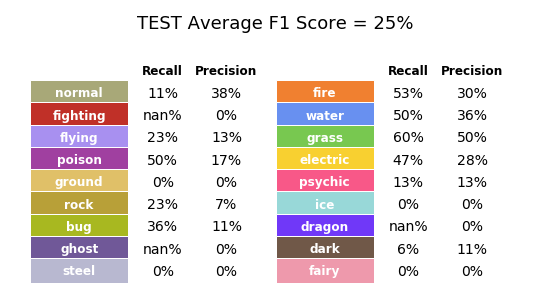

In [41]:
true_pos  = np.zeros(len(classes)) #array of number of times a class was successfully predicted
false_pos = np.zeros(len(classes)) #array of number of times a class was guessed when it should NOT have been guessed
false_neg = np.zeros(len(classes)) #array of number of times a class was not guessed when it should have been guessed
actual_dist = np.zeros(len(classes)) #array of actual number of classes present in the test set

correct_pokemon = [] #list of Pokemon that were perfectly predicted 
pokemon_guesses = {} #dictionary of Pokemon and the NN's type guess
threshold = 0.5

if use_cuda:
    #bring back to CPU so that we can do train/test evaluation
    net.cpu()

with torch.no_grad():
    for i, (minibatch, index) in enumerate(loader):
        images, labels = minibatch["image"], minibatch["labels"]
        images = images.float()
        labels = labels.float()
        outputs = net(images)
        
        for j in range(images.shape[0]):
            
            #see which indices are above our threshold
            poss_indices = outputs[j] >= threshold
            
            #we haven't identified a type! pick the largest type as the prediction
            if(sum(poss_indices) < 1):
                big_class_index = np.argmax(outputs[j].numpy())
                outputs[j] = torch.zeros(outputs[j].shape, dtype=torch.uint8)
                outputs[j][big_class_index] = 1
                
            #there are too many types identified! Pick the largest two
            elif(sum(poss_indices) > 2):
                temp_outputs = outputs[j].numpy()
                big_class_index = np.argsort(temp_outputs)[-2:]
                outputs[j] = torch.zeros(outputs[j].shape, dtype=torch.uint8)
                outputs[j][big_class_index] = 1
                
            #only 1 or 2 classes beat the threshold! Set only those to 1; everything else to 0
            else:
                outputs[j] = torch.zeros(outputs[j].shape, dtype=torch.uint8)
                outputs[j][poss_indices] = 1
            
            #create a dictionary of Pokemon and the NN's prediction of its typing
            predicted_type = [classes[c] for c in range(len(classes)) if outputs[j][c] == 1]
            pokemon_guesses[theset.getpokemon(index.numpy()[j])] = predicted_type
            #print(theset.getpokemon(index.numpy()[j]), "\'s type :: ", predicted_type)
            
            
            #Gather NN stats
            numpy_labels  = labels[j].numpy()
            numpy_outputs = outputs[j].numpy()
            
            #number of Pokemon perfectly guessed by NN
            if(np.array_equal(numpy_labels, numpy_outputs)):
                correct_pokemon.append(theset.getpokemon(index.numpy()[j]))
            
            #number of classes present in the test set
            actual_dist[numpy_labels == 1] += 1
            
            #counts the number of correctly identified classes
            #also counts the number of guessed classes by the NN
            for t in range(len(classes)):
                if numpy_labels[t] ==1 and numpy_outputs[t] == 1:
                    true_pos[t] += 1
                    
                if numpy_labels[t] == 1 and numpy_outputs[t] == 0:
                    false_pos[t] += 1
                
                if numpy_labels[t] == 0 and numpy_outputs[t] == 1:
                    false_neg[t] += 1
            
            
       # _, predicted = torch.max(outputs, 1)

         # following code is onlyl for single image identification
#         for j in range(images.shape[0]):
#             print(testset.getpokemon(index.numpy()[j])," \'s type:: ", classes[predicted[j]])
#             if(labels.numpy()[j][predicted[j]] == 1):
#                 class_correct[predicted[j]] = class_correct[predicted[j]]+1
#                 correct_pokemon.append(testset.getpokemon(index.numpy()[j]))
    
metrics = getMetrics(true_pos, false_pos, false_neg, actual_dist)

recall = metrics["recall"]
precision = metrics["precision"]
F1 = metrics["F1"]

mean_Recall = metrics["mean_recall"]
mean_Precision = metrics["mean_precision"]
mean_F1 = metrics["mean_F1"]
    
plot_evaluation(somevar.upper(), "Recall", recall, "Precision", precision, "F1", mean_F1)

print("True Pos :: ", true_pos)
print("False Neg :: ", false_neg)
print("False Pos :: ", false_pos)
print("****************************************")
print("Correctly identified class percentage (True Pos):: ", true_pos/actual_dist)
print("Recall (average) :: ", mean_Recall)
print("Precision (average) :: ", mean_Precision)
print("F1 Score (average) :: ", mean_F1)
print("Correctly identified Pokemon percentage :: ", len(correct_pokemon)/theset.__len__())
print("Perfectly identified Pokemon :: ")
for pkm in correct_pokemon:
    print(pkm, " :: ", pokemon_guesses[pkm])
    

#print("Random Guess accuracy :: ", (1/18))


In [17]:
ded = np.array(classes)
print(type(ded))
print(len(ded))
print(ded)
print(precision)
print(recall)

<class 'numpy.ndarray'>
18
['normal' 'fighting' 'flying' 'poison' 'ground' 'rock' 'bug' 'ghost'
 'steel' 'fire' 'water' 'grass' 'electric' 'psychic' 'ice' 'dragon' 'dark'
 'fairy']
[0.22 0.06 0.05 0.08 0.07 0.12 0.08 0.03 0.07 0.07 0.4  0.36 0.2  0.18
 0.   0.   0.11 0.02]
[0.19 0.1  0.08 0.13 0.07 0.42 0.12 0.14 0.14 0.13 0.28 0.42 0.33 0.22
 0.   0.   0.09 0.11]


torch.Size([3, 64, 64])


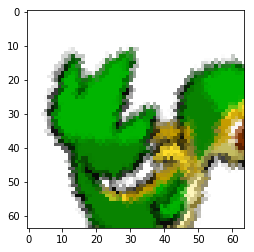

In [34]:
#Attempting to show the predicted Pokemon Type vs its Actual Type
#Fix this later

def plot_sprite(sprite,type_1=1,type_2=None,pred=None,type_dict = load_type_dict(),save=None,save_path="./classification"):
    #Definindo as dimensões do Grid
    if pred:
        grid_rows = 2
        grid_cols = 2
        figsize = (8, 4.4)        
        width_ratios = (1, 1)
        sprite_grid = 0
        pred_grid = 1
        type_grid = 2
    else:
        grid_rows = 2
        grid_cols = 1
        figsize = (4, 4.4)
        width_ratios = (1,)
        sprite_grid = 0
        type_grid = 1
        
        
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(grid_rows,grid_cols, height_ratios = (10,1), width_ratios = width_ratios)
    
    #Plotando o sprite do Pokemon
    ax_sprite = plt.subplot(gs[sprite_grid])
    ax_sprite.imshow(color.hsv2rgb(sprite))    
    
    #Plotando o tipo verdadeiro do pokemon
    ax_type = plt.subplot(gs[type_grid])
    plt.axis("off")
    
    type_box_01 = patches.Rectangle(
        (0,0),
        0.5 if type_2 else 1,  
        1,  
        fc = type_dict[type_1]["color"],
        ec = "#FFFFFF"
    )    
    ax_type.add_patch(type_box_01)
    ax_type.annotate(type_dict[type_1]["label"], (0.25 if type_2 else 0.5, 0.5), color='w', weight='bold', 
                fontsize=12, ha='center', va='center')    
    if type_2:
        type_box_02 = patches.Rectangle(
            (0.5,0),
            0.5,  
            1,  
            fc = type_dict[type_2]["color"],
            ec = "#FFFFFF"
        )            
        ax_type.add_patch(type_box_02)
        ax_type.annotate(type_dict[type_2]["label"], (0.75, 0.5), color='w', weight='bold', 
                    fontsize=12, ha='center', va='center')       

    
    #Plotando as previsões
    if pred:
        ax_pred = plt.subplot(gs[pred_grid])
        plt.axis("off")

        pred_list = list(pred.items())
        pred_list = sorted(pred_list, key = lambda x: x[1],reverse = True)    
        for idx, (pred_type, pred_prob) in enumerate(pred_list):
            pred_box = patches.Rectangle(
                (0,0.8-0.2*idx),
                0.5,
                0.2,
                fc = type_dict[pred_type]["color"],
                ec = "#FFFFFF"            
            )
            ax_pred.add_patch(pred_box)
            ax_pred.annotate(type_dict[pred_type]["label"], (0.25, 0.9-0.2*idx), color='#FFFFFF', weight='bold', 
                        fontsize=12, ha='center', va='center')       
            ax_pred.annotate("{:.0%}".format(pred_prob), (0.75, 0.9-0.2*idx), color='#000000', weight='bold', 
                        fontsize=16, ha='center', va='center')   
    if save:
        correct_path = os.path.join(save_path,"correct")
        wrong_path = os.path.join(save_path,"wrong")
        if not os.path.exists(correct_path):
            os.makedirs(correct_path)
        if not os.path.exists(wrong_path):
            os.makedirs(wrong_path)      
        if type_1 == pred_list[0][0]:
            save_file = os.path.join(correct_path,save)            
        else:
            save_file = os.path.join(wrong_path,save)
        fig.savefig(save_file)
        

dataiter = iter(loader)

#for i in range(0,1):
minibatch, index = dataiter.next()
images, labels = minibatch["image"], minibatch["labels"]

sprite = images[0]
print(sprite.shape)
plt.imshow(sprite.numpy().transpose((1,2,0)))
    

In [18]:
# def load_type_dict():
#     data_path = os.path.join(os.getcwd(),"data")
#     types_file = "types.csv"
#     types_path = os.path.join(data_path,types_file)
#     types_csv = pd.read_csv(types_path)
#     types_csv = types_csv.to_dict(orient="records")

#     type_dict={}

#     for i in range(0, len(types_csv)) :
#         type_dict[i] = {"label":types_csv[i]["identifier"], 
#                         "color":types_csv[i]["color"]}
#     return type_dict
        
tttt =load_type_dict()
print(tttt)

{0: {'label': 'normal', 'color': '#A8A878'}, 1: {'label': 'fighting', 'color': '#C03028'}, 2: {'label': 'flying', 'color': '#A890F0'}, 3: {'label': 'poison', 'color': '#A040A0'}, 4: {'label': 'ground', 'color': '#E0C068'}, 5: {'label': 'rock', 'color': '#B8A038'}, 6: {'label': 'bug', 'color': '#A8B820'}, 7: {'label': 'ghost', 'color': '#705898'}, 8: {'label': 'steel', 'color': '#B8B8D0'}, 9: {'label': 'fire', 'color': '#F08030'}, 10: {'label': 'water', 'color': '#6890F0'}, 11: {'label': 'grass', 'color': '#78C850'}, 12: {'label': 'electric', 'color': '#F8D030'}, 13: {'label': 'psychic', 'color': '#F85888'}, 14: {'label': 'ice', 'color': '#98D8D8'}, 15: {'label': 'dragon', 'color': '#7038F8'}, 16: {'label': 'dark', 'color': '#705848'}, 17: {'label': 'fairy', 'color': '#EE99AC'}}


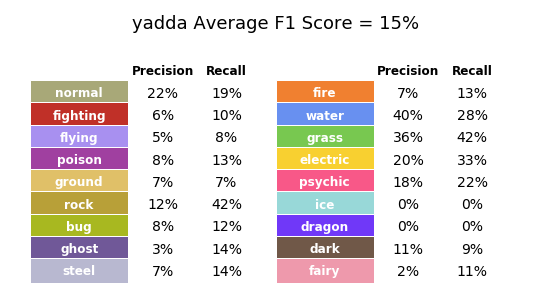

In [19]:
# def plot_evaluation(label,recall, precision, mean_f1, type_dict = load_type_dict()):
# #     y_pred = np.argmax(y_pred,axis=1)+1
# #     y_true = np.argmax(y_true,axis=1)+1    
# #     #Evaluate model metrics over input data
# #     recall = recall_score(y_true, y_pred, average=None)
# #     precision = precision_score(y_true, y_pred, average=None)
# #     accuracy = accuracy_score(y_true, y_pred)
    
#     #Create grid for plotting
#     fig = plt.figure(figsize=(8.8,5))
#     gs = gridspec.GridSpec(2,1, height_ratios = (1,9))
       
#     #Plotting model-level metrics
#     ax = plt.subplot(gs[0])     
#     ax.axis("off")    
#     ax.annotate("{} Average F1 Score = {:.0%}".format(label, mean_f1), (0.5, 0.5), color='#000000', 
#                 fontsize=18, ha='center', va='center')     
        
#     #Ploting class-level metrics
#     ax = plt.subplot(gs[1]) 
#     ax.axis("off")    
    
#     #In some cases, there are no records of some classes (usually 3:Flying) Here, we fill
#     #up the missing classes with 'None' values.
#     unique_labels = np.arange(start=0, stop=len(classes))
#     metrics = dict( (key, {"recall" : None, "precision" : None}) for key in range(0,18))
#     for key, v_recall, v_precision in zip(unique_labels, recall, precision):
#         metrics[key]["recall"] = v_recall
#         metrics[key]["precision"] = v_precision

#     #Writing the headers of the class table
#     ax.annotate("Precision", (0.27, 19/20), color='#000000', weight='bold', 
#                 fontsize=12, ha='center', va='center')     
#     ax.annotate("Recall", (0.4, 19/20), color='#000000', weight='bold', 
#                 fontsize=12, ha='center', va='center')        
#     ax.annotate("Precision", (0.77, 19/20), color='#000000', weight='bold', 
#                 fontsize=12, ha='center', va='center')        
#     ax.annotate("Recall", (0.9, 19/20), color='#000000', weight='bold', 
#                 fontsize=12, ha='center', va='center')            
    
#     #Writing the metrics for each class
#     for i, (pkm_type, metric) in enumerate(metrics.items()):
#         column = int(i/9)
#         row = i % 9 + 1
#         left = column*0.5
#         top = 1.0-(row+1)*1/10
#         type_box = patches.Rectangle(
#             (left,top),
#             0.2,
#             1/9,
#             fc = type_dict[pkm_type]["color"],
#             ec = "#FFFFFF"            
#         ) 
#         ax.add_patch(type_box)
#         ax.annotate(type_dict[pkm_type]["label"], (left+0.1, top+1/20), color='#FFFFFF', weight='bold', 
#                     fontsize=12, ha='center', va='center')  
#         #Precision
#         if metric["precision"] is not None:
#             ax.annotate("{:.0%}".format(metric["precision"]), (left+0.27, top+1/20), color='#000000', 
#                         fontsize=14, ha='center', va='center')    
#         #Recall
#         if metric["recall"] is not None:
#             ax.annotate("{:.0%}".format(metric["recall"]), (left+0.40, top+1/20), color='#000000', 
#                         fontsize=14, ha='center', va='center') 
            
plot_evaluation("yadda",recall, precision, mean_F1)

# Print Precision, Recall, and F1 in Table Format

In [108]:
rows = np.row_stack((precision, recall, F1))
results_df = pd.DataFrame(rows, columns=classes)
results_df.insert(loc=0, column="Results", value=["Precision", "Recall", "F1"])

print(results_df)

# print(classes)
# print("Actual classes :: ")
# print(actual_class)
# print("***********")
# print("Guessed classes :: ")
# print(guessed_classes)

     Results  normal  fighting  flying  poison  ground  rock   bug  ghost  \
0  Precision    0.22      0.06    0.05    0.08    0.07  0.12  0.08   0.03   
1     Recall    0.19      0.10    0.08    0.13    0.07  0.42  0.12   0.14   
2         F1    0.20      0.08    0.06    0.10    0.07  0.19  0.10   0.05   

   steel  fire  water  grass  electric  psychic  ice  dragon  dark  fairy  
0   0.07  0.07   0.40   0.36      0.20     0.18  0.0     0.0  0.11   0.02  
1   0.14  0.13   0.28   0.42      0.33     0.22  0.0     0.0  0.09   0.11  
2   0.09  0.09   0.33   0.39      0.25     0.20  NaN     NaN  0.10   0.03  


In [109]:
for key in pokemon_guesses:
    print(key, " :: ", pokemon_guesses[key])

/home/ubuntu/PokemonTypeNN/data/bw/rowlet.png  ::  ['fairy']
/home/ubuntu/PokemonTypeNN/data/bw-back/rowlet.png  ::  ['fairy']
/home/ubuntu/PokemonTypeNN/data/xydex/rowlet.png  ::  ['fairy']
/home/ubuntu/PokemonTypeNN/data/bw-back/dartrix.png  ::  ['normal']
/home/ubuntu/PokemonTypeNN/data/xydex/dartrix.png  ::  ['dragon']
/home/ubuntu/PokemonTypeNN/data/bw/dartrix.png  ::  ['grass']
/home/ubuntu/PokemonTypeNN/data/bw-back/decidueye.png  ::  ['grass']
/home/ubuntu/PokemonTypeNN/data/bw/decidueye.png  ::  ['psychic']
/home/ubuntu/PokemonTypeNN/data/xydex/decidueye.png  ::  ['grass']
/home/ubuntu/PokemonTypeNN/data/bw-back/litten.png  ::  ['water']
/home/ubuntu/PokemonTypeNN/data/xydex/litten.png  ::  ['fighting']
/home/ubuntu/PokemonTypeNN/data/bw/litten.png  ::  ['bug']
/home/ubuntu/PokemonTypeNN/data/xydex/torracat.png  ::  ['bug']
/home/ubuntu/PokemonTypeNN/data/bw-back/torracat.png  ::  ['dark']
/home/ubuntu/PokemonTypeNN/data/bw/torracat.png  ::  ['bug']
/home/ubuntu/PokemonTypeNN/

In [32]:
# Test the train/test loader

for i in range(len(trainset)):
    sample = trainset[i]
    
    print(i, sample["image"].size(), sample["labels"].size())
    
    if(i == 3):
        break


0 torch.Size([3, 64, 64]) torch.Size([1, 18])
1 torch.Size([3, 64, 64]) torch.Size([1, 18])
2 torch.Size([3, 64, 64]) torch.Size([1, 18])
3 torch.Size([3, 64, 64]) torch.Size([1, 18])


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [11]:
dic = {"a":[1,2,3,4],"b": "led", "c":10}
x, y, z = dic
print(x)

a


# Test the PokemonDataset

/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


0 (64, 64, 4) (1, 18)
[[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0]]
1 (64, 64, 4) (1, 18)
[[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0]]
2 (64, 64, 4) (1, 18)
[[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0]]
3 (64, 64, 4) (1, 18)
[[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0]]


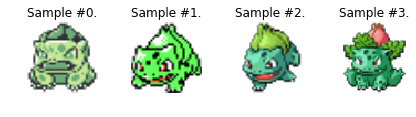

In [71]:
fig = plt.figure()

for i in range(len(trainset)):
    sample = trainset[i]
    
    print(i, sample["image"].shape, sample["labels"].shape)
    
    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    ax.set_title("Sample #{}.".format(i))
    ax.axis("off")
    plt.imshow(sample["image"])
    print(sample["labels"])
    
    if i == 3:
        plt.show()
        break